# Frequency analysis

In [1]:
%load_ext autoreload
%autoreload all

In [2]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# local modules
import sys
sys.path.append("..")

from _helpers import constants
from _helpers import functions as hf

In [4]:
# load data
df_train = pd.read_csv(constants.TRAIN,sep=",")

## Dataset shape 

Let's look at the dataset, how many rows and columns it has

In [5]:
df_train.shape

(15932992, 12)

In [6]:
df_train.head(20)

,user_id,session_id,timestamp,step,action_type,reference,platform,city,device,current_filters,impressions,prices
0,00RL8Z82B2Z1,aff3928535f48,1541037460,1,search for poi,Newtown,AU,"Sydney, Australia",mobile,NaN,NaN,NaN
1,00RL8Z82B2Z1,aff3928535f48,1541037522,2,interaction item image,666856,AU,"Sydney, Australia",mobile,NaN,NaN,NaN
2,00RL8Z82B2Z1,aff3928535f48,1541037522,3,interaction item image,666856,AU,"Sydney, Australia",mobile,NaN,NaN,NaN
3,00RL8Z82B2Z1,aff3928535f48,1541037532,4,interaction item image,666856,AU,"Sydney, Australia",mobile,NaN,NaN,NaN
4,00RL8Z82B2Z1,aff3928535f48,1541037532,5,interaction item image,109038,AU,"Sydney, Australia",mobile,NaN,NaN,NaN
5,00RL8Z82B2Z1,aff3928535f48,1541037532,6,interaction item image,666856,AU,"Sydney, Australia",mobile,NaN,NaN,NaN
6,00RL8Z82B2Z1,aff3928535f48,1541037532,7,interaction item image,109038,AU,"Sydney, Australia",mobile,NaN,NaN,NaN
7,00RL8Z82B2Z1,aff3928535f48,1541037532,8,interaction item image,666856,AU,"Sydney, Australia",mobile,NaN,NaN,NaN
8,00RL8Z82B2Z1,aff3928535f48,1541037542,9,interaction item image,109038,AU,"Sydney, Australia",mobile,NaN,NaN,NaN
9,00RL8Z82B2Z1,aff3928535f48,1541037542,10,interaction item image,109038,AU,"Sydney, Australia",mobile,NaN,NaN,NaN


## Attributes

In [7]:
df_train.columns.unique()

Index(['user_id', 'session_id', 'timestamp', 'step', 'action_type',
       'reference', 'platform', 'city', 'device', 'current_filters',
       'impressions', 'prices'],
      dtype='object')

According to [dataset author\'s description](https://recsys.trivago.cloud/challenge/dataset/), the columns above contain following:

*   `user_id`: identifier of the user
*   `session_id`: identifier of each session
*   `timestamp`:  UNIX timestamp for the time of the interaction
*   `step`: step in the sequence of actions within the session
*   `action_type`: identifier of the action that has been taken by the user.
    *   **clickout item**: user makes a click-out on the item and gets forwarded to a partner website. The reference value for this action is the item_id. Other items that were displayed to the user and their associated prices are listed under the ‘impressions’ and ‘prices’ column for this action.
    *   **interaction item rating**: user interacts with a rating or review of an item. The reference value for this action is the item id.
    *   **interaction item info**: user interacts with item information. The reference value for this action is the item id.
    *   **interaction item image**: user interacts with an image of an item. The reference value for this action is the item id.
    *   **interaction item deals**: user clicks on the view more deals button. The reference value for this action is the item id.
    *   **change of sort order**: user changes the sort order. The reference value for this action is the sort order description.
    *   **filter selection**: user selects a filter. The reference value for this action is the filter description.
    *   **search for item**:  user s user searches for a destination. The reference value for this action is the name of the destination.
    *   **search for poi**: user searches for a point of interest (POI). The reference value for this action is the name of the POI.
*   `reference`: reference value of the action as described for the different action types
*   `platform`: country platform that was used for the search, e.g.  [trivago.de](http://trivago.de) (DE) or [trivago.com](http://trivago.com) (US)
*   `city`: name of the current city of the search context
*   `device`: device that was used for the search
*   `current_filters`: list of pipe-separated filters that were active at the given timestamp
*   `impressions`: list of pipe-separated items that were displayed to the user at the time of a click-out (see action_type = clickout_item)
*   `prices`:  list of pipe-separated prices of the items that were displayed to the user at the time of a click-out (see action_type = clickout_item)

### user_id

Categorical attribute representing unique identifier of the user, stored with string id

In [8]:
df_train.user_id.head(10)

0    00RL8Z82B2Z1
1    00RL8Z82B2Z1
2    00RL8Z82B2Z1
3    00RL8Z82B2Z1
4    00RL8Z82B2Z1
5    00RL8Z82B2Z1
6    00RL8Z82B2Z1
7    00RL8Z82B2Z1
8    00RL8Z82B2Z1
9    00RL8Z82B2Z1
Name: user_id, dtype: object

In [9]:
df_train.user_id.shape[0]

15932992

In [10]:
df_train.user_id.unique().shape[0]

730803

#### Number of actions of distinct users

Text(0.5, 1.0, 'Number of user occurences in dataset (actions)')

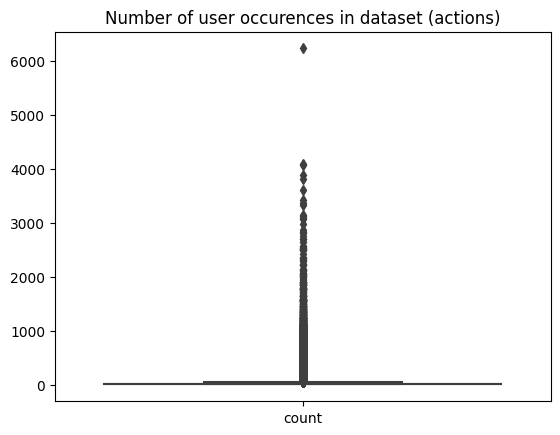

In [11]:
user_id_count = df_train.groupby('user_id').agg({'session_id':'first','user_id':'count'}).rename(columns={'user_id': 'count'}).reset_index()[['user_id','session_id','count']]
sns.boxplot(data=user_id_count).set_title('Number of user occurences in dataset (actions)')

In [12]:
user_id_count.describe()

,count
count,730803.000000
mean,21.802034
std,64.406425
min,1.000000
25%,2.000000
50%,5.000000
75%,17.000000
max,6230.000000


Text(0.5, 1.0, 'Number of actions (N) of distinct user in the dataset')

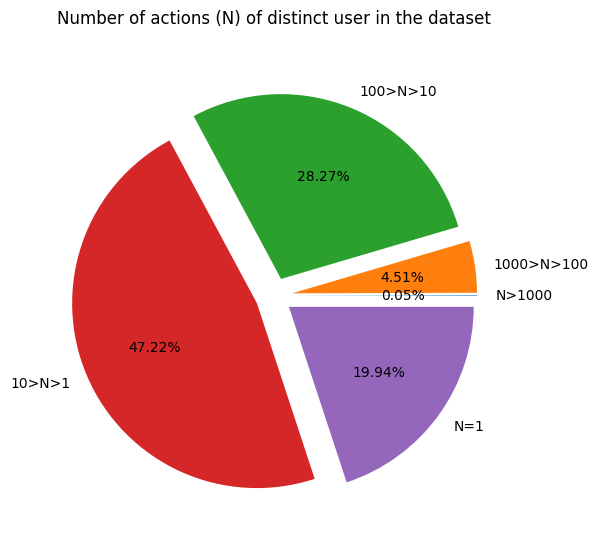

In [13]:
user_id_groups = pd.DataFrame({
    'type': [
        'N>1000',
        '1000>N>100',
        '100>N>10',
        '10>N>1',
        'N=1'
    ],
    'count': [
        user_id_count[user_id_count['count'] > 1000].count()[0],
        user_id_count[(user_id_count['count'] > 100) & (user_id_count['count'] < 1000)].count()[0],
        user_id_count[(user_id_count['count'] > 10) & (user_id_count['count'] < 100)].count()[0],
        user_id_count[(user_id_count['count'] > 1) & (user_id_count['count'] < 10)].count()[0],
        user_id_count[user_id_count['count'] == 1].count()[0]
    ]
});

fig, axes = plt.subplots(figsize = (10,6))
axes.pie(x=user_id_groups['count'], labels = user_id_groups['type'], explode=[0.1]*5, autopct="%.2f%%")
plt.title("Number of actions (N) of distinct user in the dataset",pad=30)

According to the boxplot as well as the pie chart we see that most of the values are in tens, but we do have some outliers with large number of actions. We may deal with them later, in the dropping phase.

### session_id

Categorical attribute representing unique identifier of the session, stored with string id

In [14]:
df_train.session_id.head(10)

0    aff3928535f48
1    aff3928535f48
2    aff3928535f48
3    aff3928535f48
4    aff3928535f48
5    aff3928535f48
6    aff3928535f48
7    aff3928535f48
8    aff3928535f48
9    aff3928535f48
Name: session_id, dtype: object

In [15]:
df_train.session_id.unique().shape[0]

910683

In [16]:
df_train.groupby(['user_id','session_id']).agg({'user_id':'first','session_id':'first'}).reset_index(drop=True).shape[0]

910683

This shows that the dataset only contains unique user session pairs.

#### Number of sessions per user

Text(0.5, 1.0, 'Number of sessions per user')

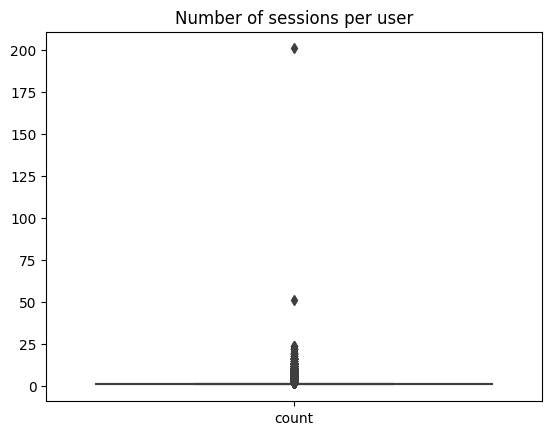

In [17]:
u_session_count = df_train.groupby(['user_id'])['session_id'].nunique().reset_index(name='count')
sns.boxplot(data=u_session_count).set_title('Number of sessions per user')

In [18]:
u_session_count.describe()

,count
count,730803.000000
mean,1.246140
std,0.750184
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,201.000000


Text(0.5, 1.0, 'Number of sessions (N) of distinct user in the dataset')

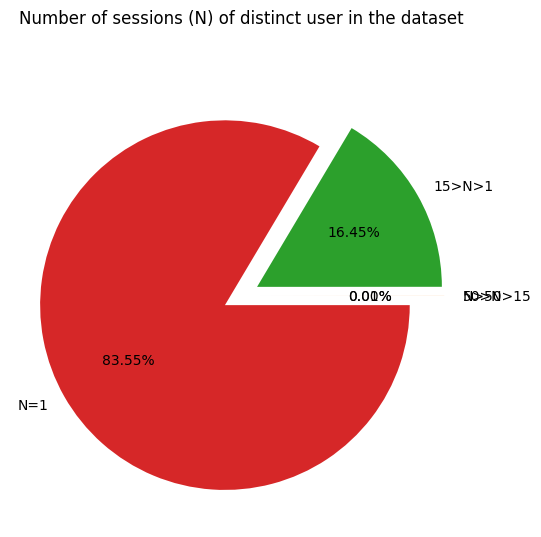

In [19]:
u_session_count_groups = pd.DataFrame({
    'type': [
        'N>50',
        '50>N>15',
        '15>N>1',
        'N=1'
    ],
    'count': [
        u_session_count[u_session_count['count'] > 50].count()[0],
        u_session_count[(u_session_count['count'] > 15) & (u_session_count['count'] < 50)].count()[0],
        u_session_count[(u_session_count['count'] > 1) & (u_session_count['count'] < 50)].count()[0],
        u_session_count[u_session_count['count'] == 1].count()[0],
    ]
});

fig, axes = plt.subplots(figsize = (10,6))
axes.pie(x=u_session_count_groups['count'], labels = u_session_count_groups['type'], explode=[0.1]*4, autopct="%.2f%%")
plt.title("Number of sessions (N) of distinct user in the dataset",pad=30)

From graph, we might see that majority of the user has a single session.

### timestamp

This attribute represents UNIX timestamp of the users' interaction

In [20]:
df_train.timestamp.head(10)

0    1541037460
1    1541037522
2    1541037522
3    1541037532
4    1541037532
5    1541037532
6    1541037532
7    1541037532
8    1541037542
9    1541037542
Name: timestamp, dtype: int64

In [21]:
min_time = datetime.fromtimestamp(df_train.timestamp.min())
max_time = datetime.fromtimestamp(df_train.timestamp.max())

print(f'{min_time} - {max_time}')

2018-11-01 00:00:08 - 2018-11-06 23:59:59


The time range from which this data comes from is approximiately 6 days.

#### Length of the sesssion (in minutes)

In [22]:
u_actions_per_session = df_train.groupby(['user_id','session_id'],as_index=False) \
.agg(
    steps=('step','count'),
    first_timestamp=('timestamp','first'),
    last_timestamp=('timestamp','last'),
    session_length=('timestamp', lambda x: (x.max()-x.min())),
)

def avg_step_duration(row):
    return row['session_length'] / row['steps']

def seconds_to_minutes(seconds):
    return round(seconds/60,2)

# transform session length into minutes
u_actions_per_session['session_length_minutes'] = u_actions_per_session['session_length'].apply(seconds_to_minutes);

# calculate avergate duration of step
u_actions_per_session['avg_step_duration_seconds'] = u_actions_per_session.apply(avg_step_duration,axis=1);

u_actions_per_session

,user_id,session_id,steps,first_timestamp,last_timestamp,session_length,session_length_minutes,avg_step_duration_seconds
0,0001VQMGUI65,466687f1875ee,18,1541075929,1541076413,484,8.07,26.888889
1,0003QTCX5MJX,6e81f1bdeb75d,4,1541441455,1541441472,17,0.28,4.250000
2,0004IOZI7CKF,0146f7cb014ba,5,1541266717,1541266868,151,2.52,30.200000
3,0004WCFRV3FB,b47e1ccca2b97,2,1541421780,1541421814,34,0.57,17.000000
4,0006W0R5A5V8,85501a9f27263,1,1541385464,1541385464,0,0.00,0.000000
...,...,...,...,...,...,...,...,...
910678,ZZZPKIEICNT9,3d1050e3a9443,1,1541065271,1541065271,0,0.00,0.000000
910679,ZZZPQ336U50Y,064c82a3bcbbd,12,1541252236,1541255539,3303,55.05,275.250000
910680,ZZZRFN2DZ2BV,2af5b0a2ba2f8,34,1541165368,1541167476,2108,35.13,62.000000
910681,ZZZRTATPZ6I4,037a55441944f,1,1541342506,1541342506,0,0.00,0.000000


[Text(0.5, 1.0, 'Length of the session'), Text(0, 0.5, 'Time (min)')]

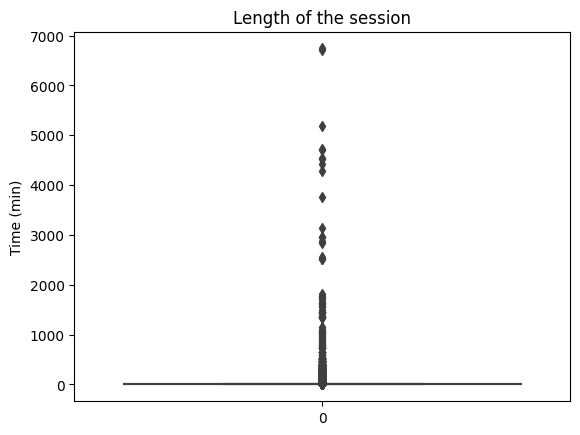

In [23]:
sns.boxplot(data=u_actions_per_session.session_length_minutes).set(title='Length of the session',ylabel="Time (min)")

7000 minutes is a long session. We might look what session it is.

In [24]:
longest_sessions = u_actions_per_session.sort_values(by="session_length_minutes",ascending=False).head(10)
longest_sessions

,user_id,session_id,steps,first_timestamp,last_timestamp,session_length,session_length_minutes,avg_step_duration_seconds
73721,2DQ7VEGMWKMC,907cb2db5cec5,3,1541100192,1541504595,404403,6740.05,134801.000000
240205,7X4FZTVRCDQA,2a181b2125efe,3,1541329853,1541103586,402729,6712.15,134243.000000
382463,DBCXN9ORT7JR,c0c2730fdde6c,243,1541041823,1541211511,311043,5184.05,1280.012346
112562,3O0IAI6ZFBGH,7a37b2c63a02f,141,1541292154,1541451149,283968,4732.80,2013.957447
694449,QP6XR22469XE,4cd200e050285,9,1541348915,1541080205,282081,4701.35,31342.333333
797705,V3P76U5ZAW70,a0163701c3369,375,1541170709,1541443671,272962,4549.37,727.898667
663069,PBIZWRQOUBVE,8c41f0b873b0b,78,1541544799,1541273981,270955,4515.92,3473.782051
240267,7X60B4XQ9F9A,1892588e0a4fc,199,1541089881,1541355226,265345,4422.42,1333.391960
552897,KM9M1H6OUC8V,14ffe9351be7c,2,1541147752,1541405239,257487,4291.45,128743.500000
889713,Z318E4ELCZDN,0187dfe7f029a,2,1541419153,1541194025,225128,3752.13,112564.000000


In [25]:
df_train[df_train.session_id == longest_sessions['session_id'].iloc[0]]

,user_id,session_id,timestamp,step,action_type,reference,platform,city,device,current_filters,impressions,prices
1195332,2DQ7VEGMWKMC,907cb2db5cec5,1541100192,1,clickout item,14893,DE,"Cologne, Germany",mobile,NaN,14893|6477|13714|6446|6435|6468|14944|51543|52...,136|134|169|167|178|81|139|89|84|84|187|110|84...
15841494,2DQ7VEGMWKMC,907cb2db5cec5,1541504562,1,clickout item,51051,DE,"Oberstaufen, Germany",mobile,NaN,141398|51612|51272|137554|3478570|51051|121851...,180|172|160|122|120|120|229|274|135|129|89|97|...
15841495,2DQ7VEGMWKMC,907cb2db5cec5,1541504595,2,clickout item,51272,DE,"Oberstaufen, Germany",mobile,NaN,141398|51612|51272|137554|3478570|51051|121851...,180|172|160|122|120|120|229|274|135|129|89|97|...


In [26]:
df_train[df_train.session_id == longest_sessions['session_id'].iloc[1]]

,user_id,session_id,timestamp,step,action_type,reference,platform,city,device,current_filters,impressions,prices
5054814,7X4FZTVRCDQA,2a181b2125efe,1541329853,1,search for destination,"Rimini, Italy",IT,"Rimini, Italy",mobile,NaN,NaN,NaN
6267791,7X4FZTVRCDQA,2a181b2125efe,1541506315,1,search for destination,"Milan, Italy",IT,"Milan, Italy",mobile,NaN,NaN,NaN
8324291,7X4FZTVRCDQA,2a181b2125efe,1541103586,1,clickout item,94907,IT,"Giardini-Naxos, Italy",mobile,NaN,94907|101278|82654|23607|23610|45848|1203406|2...,82|55|87|187|85|98|184|94|86|111|144|87|223|49...


There's some dirty data in there. Possible candidate for dropping duplicated session_id - step pairs

### step

Step is a attribute representing step order number in the sequence of actions within the session

#### Number of steps in distinct sessions

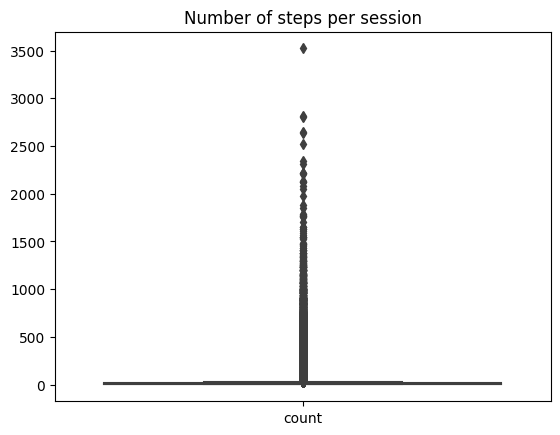

In [27]:
session_action_count = df_train.groupby(['session_id'])['step'].count().reset_index(name="count")
sns.boxplot(data=session_action_count).set(title="Number of steps per session");

In [28]:
session_action_count.describe()

,count
count,910683.000000
mean,17.495651
std,48.181687
min,1.000000
25%,2.000000
50%,4.000000
75%,13.000000
max,3522.000000


Text(0.5, 1.0, 'Number of steps (N) of distinct sessions')

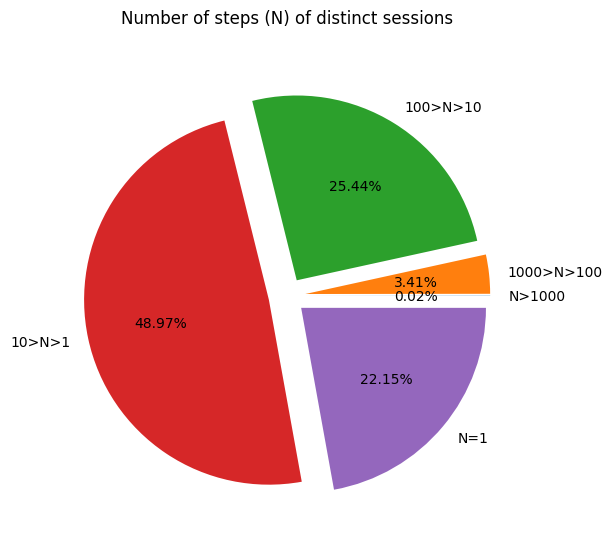

In [29]:
session_action_count_groups = pd.DataFrame({
   'type': [
        'N>1000',
        '1000>N>100',
        '100>N>10',
        '10>N>1',
        'N=1'
    ],
    'count': [
        session_action_count[session_action_count['count'] > 1000].count()[0],
        session_action_count[(session_action_count['count'] > 100) & (session_action_count['count'] < 1000)].count()[0],
        session_action_count[(session_action_count['count'] > 10) & (session_action_count['count'] < 100)].count()[0],
        session_action_count[(session_action_count['count'] > 1) & (session_action_count['count'] < 10)].count()[0],
        session_action_count[session_action_count['count'] == 1].count()[0]
    ]
});

fig, axes = plt.subplots(figsize = (10,6))
axes.pie(x=session_action_count_groups['count'], labels = session_action_count_groups['type'], explode=[0.1]*5, autopct="%.2f%%")
plt.title("Number of steps (N) of distinct sessions",pad=30)

The data is distributed relatively good. In the graph above we might see that almost half of the sessions are under 10 steps. A quarter is under 100 and the other quarter are single-step sessions.

### action_type

Identifier of the action that has been taken by the user. As descibed in the introduction, it can contain following values:

In [30]:
df_train.action_type.unique()

array(['search for poi', 'interaction item image', 'clickout item',
       'interaction item info', 'interaction item deals',
       'search for destination', 'filter selection',
       'interaction item rating', 'search for item',
       'change of sort order'], dtype=object)

Let's count them:

In [31]:
actions_count = df_train['action_type'].value_counts().reset_index(name="count").rename(columns={'index':'action_type'})
actions_count

,action_type,count
0,interaction item image,11860750
1,clickout item,1586586
2,filter selection,695917
3,search for destination,403066
4,change of sort order,400584
5,interaction item info,285402
6,interaction item rating,217246
7,interaction item deals,193794
8,search for item,152203
9,search for poi,137444


/root/miniconda3/envs/trivago/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  This is separate from the ipykernel package so we can avoid doing imports until


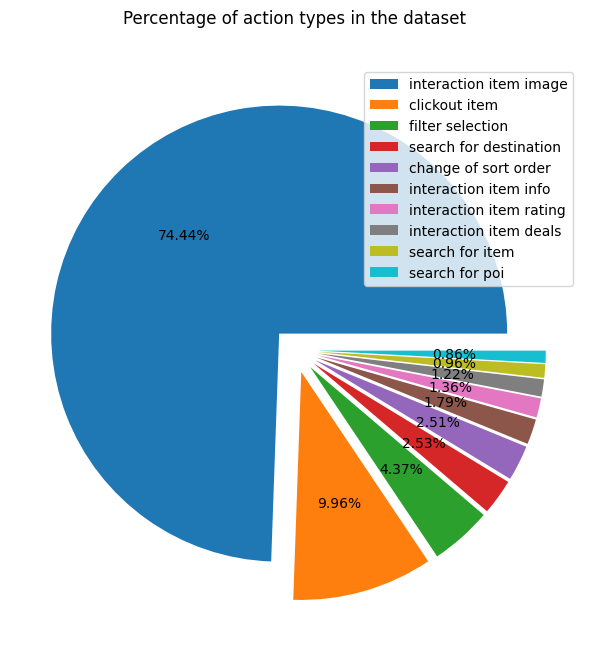

In [32]:
fig, axes = plt.subplots(figsize = (10,6))
patches = axes.pie(x=actions_count['count'], explode=[0.1]*actions_count.shape[0], autopct="%.2f%%")
plt.legend(patches,labels=actions_count['action_type'].array.to_numpy(),loc='upper right')
plt.tight_layout()
plt.title("Percentage of action types in the dataset",pad=30)
plt.show()

#### What steps are there before clickout?

In [33]:
clickout_prec_rows = df_train.sort_values(by=["user_id", "session_id", "timestamp", "step"]).groupby(['user_id','session_id'])["action_type"].shift(1).dropna()
clickout_prec_rows.unique()

array(['interaction item deals', 'interaction item image',
       'clickout item', 'interaction item rating',
       'interaction item info', 'change of sort order',
       'filter selection', 'search for destination', 'search for poi',
       'search for item'], dtype=object)

### reference

Reference value of the action as described for the different action types. This column is missing in the test dataset and is the goal of the prediction.

It is present in all action types and contains various values, according to the action_type.

In [34]:
df_train.groupby(['action_type']).agg({'reference':'first'})

,reference
action_type,
change of sort order,interaction sort button
clickout item,109038
filter selection,Very Good Rating
interaction item deals,3066244
interaction item image,666856
interaction item info,3377332
interaction item rating,749441
search for destination,"London, United Kingdom"
search for item,1258184


### platform

Categorical atribute representing comuntry platform that was used for the search, e.g.  [trivago.de](http://trivago.de) (DE) or [trivago.com](http://trivago.com) (US).

In [35]:
df_train['platform'].unique()

array(['AU', 'BR', 'FI', 'UK', 'US', 'MX', 'FR', 'IT', 'AT', 'HK', 'RU',
       'IN', 'CO', 'ES', 'CL', 'CH', 'BE', 'AR', 'NL', 'CA', 'JP', 'IE',
       'SE', 'DE', 'TH', 'MY', 'HU', 'PH', 'ZA', 'PE', 'ID', 'NZ', 'CZ',
       'KR', 'RS', 'BG', 'DK', 'HR', 'TR', 'IL', 'SG', 'EC', 'SK', 'PL',
       'NO', 'AA', 'TW', 'PT', 'RO', 'UY', 'GR', 'AE', 'SI', 'CN', 'VN'],
      dtype=object)

### city

Categorical atribute representing name of the current city of the search context

In [36]:
df_train['city'].unique()[:10]

array(['Sydney, Australia', 'Ubatuba, Brazil', 'Krakow, Poland',
       'London, United Kingdom', 'Bakersfield, USA',
       'Seminyak, Indonesia', 'Legian, Indonesia', 'Mazamitla, Mexico',
       'Alicante, Spain', 'Bolzano, Italy'], dtype=object)

In [37]:
df_train['city'].unique().shape[0]

34752

### device

Categorical attribute representing the device that was used for the search

In [38]:
df_train['device'].unique()

array(['mobile', 'desktop', 'tablet'], dtype=object)

### current_filters

A list of pipe-separated filters that were active at the given timestamp. It is present only in some action types. Example values may be:

In [39]:
df_train.groupby(['action_type']).agg({'current_filters':'first'})

,current_filters
action_type,
change of sort order,Sort by Price
clickout item,Very Good Rating|5 Star|4 Star|Hotel|Motel|Res...
filter selection,Very Good Rating
interaction item deals,None
interaction item image,Cheap
interaction item info,None
interaction item rating,None
search for destination,5 Star|4 Star
search for item,Hotel Chain


### impressions and prices

According to the author, impressions and prices are both list of pipe-separated columns that were displayed to the user at the time of a click-out.

#### When are those two attributes present?

In [40]:
df_train[df_train['prices'].notna() | df_train['impressions'].notna()]['action_type'].unique()

array(['clickout item'], dtype=object)

#### Are they the same?

In [41]:
not_na_prices = df_train[df_train['prices'].notna()].copy()
not_na_impressions = df_train[df_train['impressions'].notna()].copy()
not_na_impressions.equals(not_na_prices)

True

#### What is the number of impressions?

In [42]:
not_na_impressions.loc[:, 'impressions'] = not_na_impressions.loc[:, 'impressions'].str.split("|")

In [43]:
not_na_impressions['impressions'].apply(len).unique()

array([25,  4, 12, 16,  7, 10, 24,  8, 18, 20,  2, 21, 13,  9, 19, 14,  5,
       22, 23, 11, 15, 17,  3,  1,  6])

So we see that the number of impressions might vary.

#### Do we have clean data? Is the number of impressions and prices in distinct rows equal?

In [44]:
not_na_prices.loc[:, 'prices'] = not_na_prices.loc[:, 'prices'].str.split("|")

In [45]:
not_na_impressions['impressions'].apply(len).equals(not_na_prices['prices'].apply(len))

True

#### Do the prices come from gaussian distribution?

In [46]:
prices = df_train['prices'].dropna().str.split('|').explode('prices').astype(float)

/root/miniconda3/envs/trivago/lib/python3.7/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


The data is not Gaussian (normal).


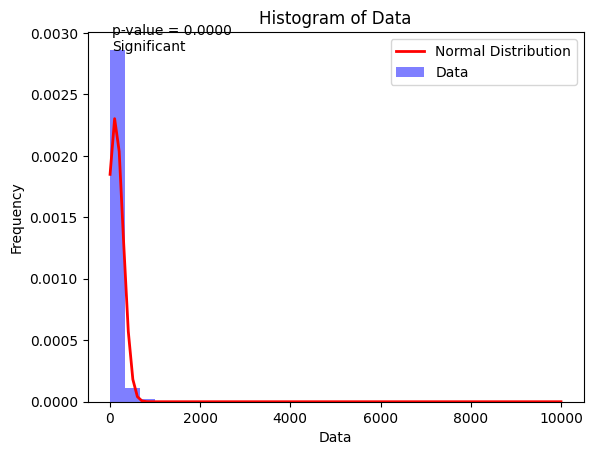

In [47]:
hf.is_gaussian(prices)

## Single-user analysis

#### Most frequent user in dataset

In [48]:
u_id = user_id_count[user_id_count['count'] > 1000].iloc[0]['user_id'];
u_actions = df_train[df_train['user_id'] == u_id];
u_actions

,user_id,session_id,timestamp,step,action_type,reference,platform,city,device,current_filters,impressions,prices
3197870,086K0G3R63E6,cd511030a1b05,1541279976,1,interaction item image,998473,BR,"Barreirinhas, Brazil",desktop,NaN,NaN,NaN
3197871,086K0G3R63E6,cd511030a1b05,1541279976,2,interaction item image,998473,BR,"Barreirinhas, Brazil",desktop,NaN,NaN,NaN
3197872,086K0G3R63E6,cd511030a1b05,1541279986,3,interaction item image,998473,BR,"Barreirinhas, Brazil",desktop,NaN,NaN,NaN
3197873,086K0G3R63E6,cd511030a1b05,1541279986,4,interaction item image,998473,BR,"Barreirinhas, Brazil",desktop,NaN,NaN,NaN
3197874,086K0G3R63E6,cd511030a1b05,1541279986,5,interaction item image,998473,BR,"Barreirinhas, Brazil",desktop,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
11236739,086K0G3R63E6,cd8fa64f0df37,1541462392,271,interaction item image,2813719,BR,"Porto Seguro, Brazil",desktop,NaN,NaN,NaN
11236740,086K0G3R63E6,cd8fa64f0df37,1541462392,272,interaction item image,2813719,BR,"Porto Seguro, Brazil",desktop,NaN,NaN,NaN
11236741,086K0G3R63E6,cd8fa64f0df37,1541462392,273,interaction item image,2813719,BR,"Porto Seguro, Brazil",desktop,NaN,NaN,NaN
11236742,086K0G3R63E6,cd8fa64f0df37,1541462392,274,interaction item image,2813719,BR,"Porto Seguro, Brazil",desktop,NaN,NaN,NaN


#### Number of steps in users' sessions

In [49]:
u_actions_grouped = u_actions.groupby('session_id',as_index=False)
u_actions_grouped['step'].last()

,session_id,step
0,2b5e1740aec75,1
1,789929800f908,1089
2,801fa2040a9e9,143
3,b8b9be6a62a12,292
4,cd511030a1b05,1150
5,cd8fa64f0df37,274
6,d87faa0e93242,121


User has a lot of actions in the dataset, but it's just a mere number of long (lot of steps) sessions. Some of the sessions seems to be really fast - doing more actions in the same second. 
We think it's a bot. We can test this hypothesis by calculating average time of that session.

#### Time of the session and average step time

In [50]:
u_actions_grouped['timestamp']\
.agg(['first','last'])

,first,last
session_id,,
2b5e1740aec75,1541507006,1541507006
789929800f908,1541517868,1541526845
801fa2040a9e9,1541540180,1541540479
b8b9be6a62a12,1541450680,1541456101
cd511030a1b05,1541279976,1541289593
cd8fa64f0df37,1541461377,1541462392
d87faa0e93242,1541033927,1541034103


In [51]:
u_actions_per_session = u_actions_grouped \
.agg(
    steps=('step','count'),
    first_timestamp=('timestamp','first'),
    last_timestamp=('timestamp','last'),
    session_length=('timestamp', lambda x: (x.max()-x.min())),
)

def avg_step_duration(row):
    return row['session_length'] / row['steps']

def seconds_to_minutes(seconds):
    return round(seconds/60,2)

# transform session length into minutes
u_actions_per_session['session_length_minutes'] = u_actions_per_session['session_length'].apply(seconds_to_minutes);

# calculate avergate duration of step
u_actions_per_session['avg_step_duration_seconds'] = u_actions_per_session.apply(avg_step_duration,axis=1);

u_actions_per_session

,session_id,steps,first_timestamp,last_timestamp,session_length,session_length_minutes,avg_step_duration_seconds
0,2b5e1740aec75,1,1541507006,1541507006,0,0.00,0.000000
1,789929800f908,1089,1541517868,1541526845,8977,149.62,8.243343
2,801fa2040a9e9,143,1541540180,1541540479,299,4.98,2.090909
3,b8b9be6a62a12,292,1541450680,1541456101,5421,90.35,18.565068
4,cd511030a1b05,1150,1541279976,1541289593,9617,160.28,8.362609
5,cd8fa64f0df37,274,1541461377,1541462392,1015,16.92,3.704380
6,d87faa0e93242,121,1541033927,1541034103,176,2.93,1.454545


#### Parallel actions

Users sessions are long but average time is under second, which may support our hypothesis about that user_id being a bot.
Let's look at the actions with the same timestamp

In [52]:
parallel_actions = u_actions.groupby(['user_id', 'session_id', 'timestamp'])\
.agg(action_type=('action_type', 'first'),count=('timestamp', 'count'))\
.reset_index()

parallel_actions[parallel_actions['count'] > 1]

,user_id,session_id,timestamp,action_type,count
6,086K0G3R63E6,789929800f908,1541518711,change of sort order,2
7,086K0G3R63E6,789929800f908,1541518768,interaction item image,2
13,086K0G3R63E6,789929800f908,1541519432,interaction item image,2
14,086K0G3R63E6,789929800f908,1541519442,interaction item image,4
16,086K0G3R63E6,789929800f908,1541519452,interaction item image,7
...,...,...,...,...,...
637,086K0G3R63E6,d87faa0e93242,1541034053,interaction item image,2
638,086K0G3R63E6,d87faa0e93242,1541034063,interaction item image,4
640,086K0G3R63E6,d87faa0e93242,1541034083,interaction item image,6
641,086K0G3R63E6,d87faa0e93242,1541034093,interaction item image,12


In [53]:
parallel_actions[parallel_actions['count'] > 1]['action_type'].unique()

array(['change of sort order', 'interaction item image',
       'interaction item info', 'interaction item rating'], dtype=object)

We don't certainly know what `interaction with image` and other action types mean, but we might assume that these actions cannot be done parallelly. We assume this user_id may represent not a human being.